# ECG

## imports

In [ ]:
!pip install wfdb

In [1]:
# ============================================
# BASIC PYTHON STANDARD LIBRARY IMPORTS
# ============================================
import os
import glob
import math
import collections
import random
import pickle      # Use 'import _pickle as pickle' ONLY if strictly needed by code
from datetime import datetime

# ============================================
# DATA & SIGNAL PROCESSING
# ============================================
import numpy as np
import pandas as pd
from scipy.signal import resample_poly

# ============================================
# BIOMEDICAL SIGNAL LIBRARY
# ============================================
import wfdb

# ============================================
# DEEP LEARNING LIBRARIES (KERAS + TENSORFLOW)
# ============================================
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Add, Conv1DTranspose, MaxPooling1D, Multiply,
    Dense, LeakyReLU, LayerNormalization, LSTM, GRU, Reshape, Lambda, UpSampling1D, Embedding, Activation, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
# If you call keras directly (separate from tf.keras) in your code, also:
import keras

# ============================================
# VISUALIZATION
# ============================================
import matplotlib.pyplot as plt

# ============================================
# EXTRAS: SKLEARN (Optionally, for Data Split)
# ============================================
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## data downloader

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Clean up the environment
!rm -r *
!ls

# Step 3: Download datasets
!wget https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip
!wget https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
!ls
print('Downloading data: Done')

# Step 4: Create a directory for data
!mkdir data

# Step 5: Unzip the datasets
!unzip qt-database-1.0.0.zip >> /dev/null
!unzip mit-bih-noise-stress-test-database-1.0.0.zip >> /dev/null

# Step 6: Move the extracted folders to the data directory
!mv qt-database-1.0.0 data/
!mv mit-bih-noise-stress-test-database-1.0.0 data/

# Step 7: Remove the zip files
!rm qt-database-1.0.0.zip
!rm mit-bih-noise-stress-test-database-1.0.0.zip
!ls
!ls data
print('Extracting data: Done')

# Step 8: Move the data directory to Google Drive
!mv data /content/drive/My\ Drive/
print('Data saved to Google Drive.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove 'drive/MyDrive': Operation canceled
rm: cannot remove 'drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove 'drive/.file-revisions-by-id': Operation canceled
rm: cannot remove 'drive/.Trash-0/files': No such file or directory
rm: cannot remove 'drive/.Trash-0/info': No such file or directory
drive
--2024-10-02 11:01:17--  https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87119682 (83M) [application/zip]
Saving to: ‘qt-database-1.0.0.zip’

qt-database-1.0.0.z 100%[===================>]  83.08M   625KB/s    in 2m 16s  

2024-10-02 11:03:34 (624 KB/s) - ‘qt-database-1.0.0.zip’ saved [87119682/87119682]

--2024-10-02 11:03:

## data

In [ ]:
QTpath = '/content/drive/MyDrive/data/qt-database-1.0.0/'
newFs = 360

namesPath = glob.glob(QTpath + "/*.dat")
QTDatabaseSignals = dict()

# Process each file in the dataset
for i in namesPath:
    aux = i.split('.dat')
    register_name = aux[0].split('/')[-1]
    signal, fields = wfdb.rdsamp(aux[0])
    qu = len(signal)

    ann = wfdb.rdann(aux[0], 'pu1')
    anntype = ann.symbol
    annSamples = ann.sample

    Anntype = np.array(anntype)
    idx = Anntype == 'p'
    Pidx = annSamples[idx]
    idxS = Anntype == '('
    Sidx = annSamples[idxS]
    idxR = Anntype == 'N'
    Ridx = annSamples[idxR]

    ind = np.zeros(len(Pidx))

    for j in range(len(Pidx)):
        arr = np.where(Pidx[j] > Sidx)
        arr = arr[0]
        ind[j] = arr[-1]

    ind = ind.astype(np.int64)
    Pstart = Sidx[ind]
    Pstart = Pstart - int(0.04 * fields['fs'])

    auxSig = signal[0:qu, 0]

    beats = list()
    for k in range(len(Pstart) - 1):
        remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k + 1])
        if np.sum(remove) < 2:
            beats.append(auxSig[Pstart[k]:Pstart[k + 1]])

    beatsRe = list()
    for k in range(len(beats)):
        L = math.ceil(len(beats[k]) * newFs / fields['fs'])
        normBeat = list(reversed(beats[k])) + list(beats[k]) + list(reversed(beats[k]))
        res = resample_poly(normBeat, newFs, fields['fs'])
        res = res[L - 1:2 * L - 1]
        beatsRe.append(res)

    QTDatabaseSignals[register_name] = beatsRe

# Step to save the processed signals to Google Drive
with open('/content/drive/My Drive/QTDatabaseSignals.pkl', 'wb') as f:
    pickle.dump(QTDatabaseSignals, f)

print('QTDatabaseSignals saved to Google Drive.')


QTDatabaseSignals saved to Google Drive.


noise(bw ma em)

In [ ]:
NSTDBPath = '/content/drive/MyDrive/data/mit-bih-noise-stress-test-database-1.0.0/bw'
signals, fields = wfdb.rdsamp(NSTDBPath)
for key in fields:
    print(key, fields[key])
np.save('/content/drive/MyDrive/data/NoiseBWL', signals)
with open('/content/drive/MyDrive/data/NoiseBWL.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


In [ ]:
NSTDBPath = '/content/drive/MyDrive/data/mit-bih-noise-stress-test-database-1.0.0/ma'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('/content/drive/MyDrive/data/NoiseMA', signals)
# Save Data
with open('/content/drive/MyDrive/data/NoiseMA.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


In [ ]:
NSTDBPath = '/content/drive/MyDrive/data/mit-bih-noise-stress-test-database-1.0.0/em'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('/content/drive/MyDrive/data/NoiseEM', signals)
# Save Data
with open('/content/drive/MyDrive/data/NoiseEM.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


## data merging

In [ ]:
print('Getting the Data ready ... ')

# The seed is used to ensure the ECG always have the same contamination level
# this enhance reproducibility
seed = 1234
np.random.seed(seed=seed)

# Load QT Database
with open('/content/drive/MyDrive/QTDatabaseSignals.pkl', 'rb') as input:
    # dict {register_name: beats_list}
    qtdb = pickle.load(input)

# Load NSTDB BWT
with open('/content/drive/MyDrive/data/NoiseBWL.pkl', 'rb') as input:
    nstdbwl = pickle.load(input)

# Load NSTDB MA
with open('/content/drive/MyDrive/data/NoiseMA.pkl', 'rb') as input:
    nstdma = pickle.load(input)

# Load NSTDB EN
with open('/content/drive/MyDrive/data/NoiseEM.pkl', 'rb') as input:
    nstdem = pickle.load(input)


# NSTDB

noise_channel1 = nstdbwl[:, 0]
noise_channel2 = nstdbwl[:, 1]

noise_channel3 = nstdma[:, 0]
noise_channel4 = nstdma[:, 1]

noise_channel5 = nstdem[:, 0]
noise_channel6 = nstdem[:, 1]


# Data split

noise_test_bwt = np.concatenate(
    (noise_channel1[0:int(noise_channel1.shape[0] * 0.13)], noise_channel2[0:int(noise_channel2.shape[0] * 0.13)]))
noise_train_bwt = np.concatenate((noise_channel1[int(noise_channel1.shape[0] * 0.13):-1],
                              noise_channel2[int(noise_channel2.shape[0] * 0.13):-1]))

noise_test_ma = np.concatenate(
    (noise_channel3[0:int(noise_channel3.shape[0] * 0.13)], noise_channel4[0:int(noise_channel4.shape[0] * 0.13)]))
noise_train_ma = np.concatenate((noise_channel3[int(noise_channel3.shape[0] * 0.13):-1],
                              noise_channel4[int(noise_channel4.shape[0] * 0.13):-1]))

noise_test_em = np.concatenate(
    (noise_channel5[0:int(noise_channel5.shape[0] * 0.13)], noise_channel6[0:int(noise_channel6.shape[0] * 0.13)]))
noise_train_em = np.concatenate((noise_channel5[int(noise_channel5.shape[0] * 0.13):-1],
                              noise_channel6[int(noise_channel6.shape[0] * 0.13):-1]))


# QTDatabase

beats_train = []
beats_test = []

test_set = ['sel123',  # Record from MIT-BIH Arrhythmia Database
            'sel233',  # Record from MIT-BIH Arrhythmia Database

            'sel302',  # Record from MIT-BIH ST Change Database
            'sel307',  # Record from MIT-BIH ST Change Database

            'sel820',  # Record from MIT-BIH Supraventricular Arrhythmia Database
            'sel853',  # Record from MIT-BIH Supraventricular Arrhythmia Database

            'sel16420',  # Record from MIT-BIH Normal Sinus Rhythm Database
            'sel16795',  # Record from MIT-BIH Normal Sinus Rhythm Database

            'sele0106',  # Record from European ST-T Database
            'sele0121',  # Record from European ST-T Database

            'sel32',  # Record from ``sudden death'' patients from BIH
            'sel49',  # Record from ``sudden death'' patients from BIH

            'sel14046',  # Record from MIT-BIH Long-Term ECG Database
            'sel15814',  # Record from MIT-BIH Long-Term ECG Database
            ]

# Creating the train and test dataset, each datapoint has 512 samples and is zero padded
# beats bigger that 512 samples are discarded to avoid wrong split beats ans to reduce
# computation.
skip_beats = 0
samples = 512
qtdb_keys = list(qtdb.keys())

for i in range(len(qtdb_keys)):
    signal_name = qtdb_keys[i]

    for b in qtdb[signal_name]:

        b_np = np.zeros(samples)
        b_sq = np.array(b)



        init_padding = 16
        if b_sq.shape[0] > (samples - init_padding):
            skip_beats += 1
            continue

        b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

        if signal_name in test_set:
            beats_test.append(b_np)
        else:
            beats_train.append(b_np)



sn_train = []
sn_test = []

noise_index = 0

rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
for i in range(len(beats_train)):
    beat_max_value = np.max(beats_train[i]) - np.min(beats_train[i])

    noise_bwt = noise_train_bwt[noise_index:noise_index + samples]
    noise_max_value_bwt = np.max(noise_bwt) - np.min(noise_bwt)
    Ase_bwt = noise_max_value_bwt / beat_max_value
    alpha = rnd_train[i] / Ase_bwt

    noise_ma = noise_train_ma[noise_index:noise_index + samples]
    noise_max_value_ma = np.max(noise_ma) - np.min(noise_ma)
    Ase_ma = noise_max_value_ma / beat_max_value
    beta = rnd_train[i] / Ase_ma

    noise_em = noise_train_bwt[noise_index:noise_index + samples]
    noise_max_value_em = np.max(noise_em) - np.min(noise_em)
    Ase_em = noise_max_value_em / beat_max_value
    gamma = rnd_train[i] / Ase_em

    signal_noise = beats_train[i] + alpha/3 * noise_bwt + beta/3 * noise_ma + gamma/3 * noise_em

    sn_train.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_train_bwt) - samples):
        noise_index = 0

noise_index = 0
rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
for i in range(len(beats_test)):
    beat_max_value = np.max(beats_test[i]) - np.min(beats_test[i])

    noise_bwt = noise_test_bwt[noise_index:noise_index + samples]
    noise_max_value_bwt = np.max(noise_bwt) - np.min(noise_bwt)
    Ase_bwt = noise_max_value_bwt / beat_max_value
    alpha = rnd_test[i] / Ase_bwt

    noise_ma = noise_test_ma[noise_index:noise_index + samples]
    noise_max_value_ma = np.max(noise_ma) - np.min(noise_ma)
    Ase_ma = noise_max_value_ma / beat_max_value
    beta = rnd_test[i] / Ase_ma

    noise_em = noise_test_bwt[noise_index:noise_index + samples]
    noise_max_value_em = np.max(noise_em) - np.min(noise_em)
    Ase_em = noise_max_value_em / beat_max_value
    gamma = rnd_test[i] / Ase_em

    signal_noise = beats_test[i] + alpha/3 * noise_bwt + beta/3 * noise_ma + gamma/3 * noise_em

    sn_test.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_test_bwt) - samples):
        noise_index = 0

X_train = np.array(sn_train)
y_train = np.array(beats_train)

X_test = np.array(sn_test)
y_test = np.array(beats_test)

X_train = np.expand_dims(X_train, axis=2)
y_train = np.expand_dims(y_train, axis=2)

X_test = np.expand_dims(X_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

Dataset = [X_train, y_train, X_test, y_test]

print('Dataset ready to use.')

Getting the Data ready ... 
Dataset ready to use.


In [5]:
print("DATASET SHAPE")
print(f'Training {X_train.shape}')
print(f'Testing {X_test.shape}')

DATASET SHAPE
Training (72002, 512, 1)
Testing (13316, 512, 1)


## noises plot

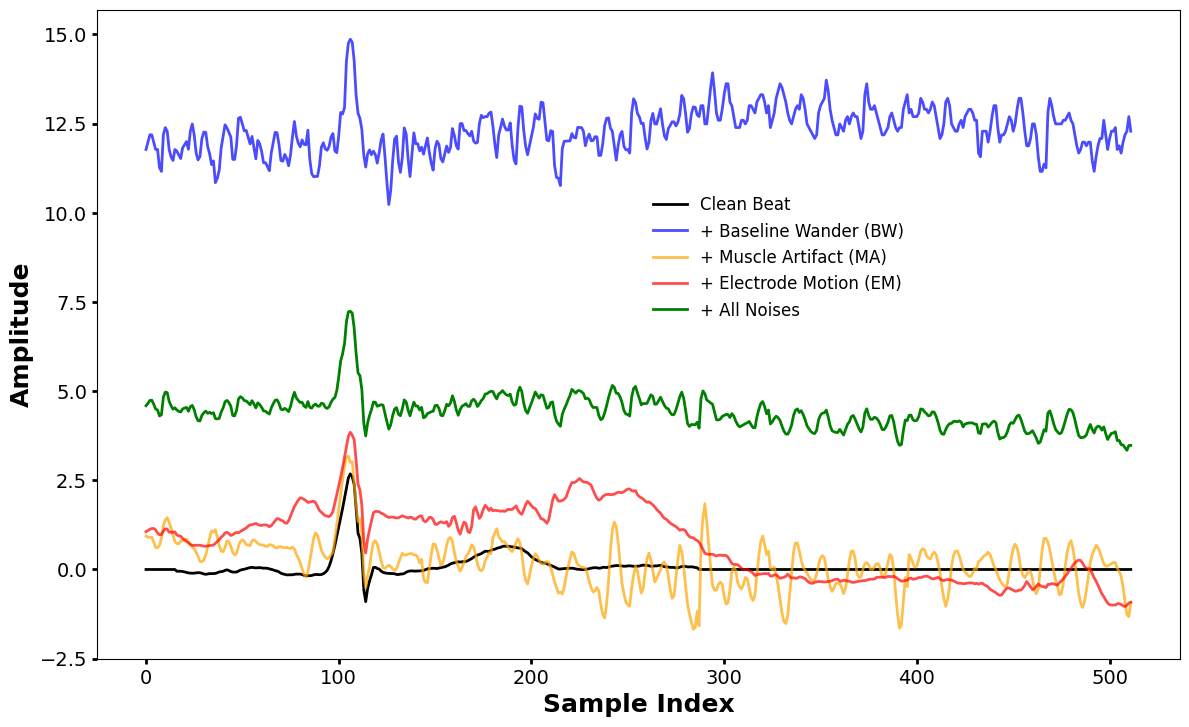

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# --------- Load Data ----------
with open('QTDatabaseSignals.pkl', 'rb') as f:
    qtdb = pickle.load(f)
with open('NoiseBWL.pkl', 'rb') as f:
    nstdbwl = pickle.load(f)
with open('NoiseMA.pkl', 'rb') as f:
    nstdma = pickle.load(f)
with open('NoiseEM.pkl', 'rb') as f:
    nstdem = pickle.load(f)

# Convert dataset to list of beats
all_beats = []
for k in qtdb.keys():
    for b in qtdb[k]:
        if len(b) <= 512-16:
            b_np = np.zeros(512)
            b_sq = np.array(b)
            b_np[16 : b_sq.shape[0]+16] = b_sq - (b_sq[0] + b_sq[-1]) / 2
            all_beats.append(b_np)
all_beats = np.array(all_beats)

# Pick a random beat to illustrate (or replace idx=0 with any index you want)
idx = 0
beat = all_beats[idx]

# --- Prepare corresponding noise samples ---
samples = 512
noise_index = 1800
bw_noise = nstdbwl[noise_index : noise_index+samples, 0]   # Baseline wander, ch1
ma_noise = nstdma[noise_index : noise_index+samples, 0]    # Muscle artifact, ch1
em_noise = nstdem[noise_index : noise_index+samples, 0]    # Electrode motion, ch1

# --- Amplitude normalization, similar to your code ---
beat_max = np.max(beat) - np.min(beat)
def scaler(noise, beat):
    return (np.max(noise) - np.min(noise)) / beat_max

alpha = 1.0 / scaler(bw_noise, beat)  # stronger noise for demo, or use random like your main code
beta  = 1.0 / scaler(ma_noise, beat)
gamma = 1.0 / scaler(em_noise, beat)

# --- Generate noisy signals ---
ecg_bw = beat + alpha * bw_noise
ecg_ma = beat + beta  * ma_noise
ecg_em = beat + gamma * em_noise
ecg_all = beat + (alpha/3 * bw_noise + beta/3 * ma_noise + gamma/3 * em_noise)

# --- Plotting ---
plt.figure(figsize=(12,8))
x = np.arange(512)
plt.plot(x, beat, label="Clean Beat", color='black', linewidth=2)
plt.plot(x, ecg_bw, label="+ Baseline Wander (BW)", color='blue', alpha=0.7, linewidth=2)
plt.plot(x, ecg_ma, label="+ Muscle Artifact (MA)", color='orange', alpha=0.7, linewidth=2)
plt.plot(x, ecg_em, label="+ Electrode Motion (EM)", color='red', alpha=0.7, linewidth=2)
plt.plot(x, ecg_all, label="+ All Noises", color='green', linewidth=2)

# Set labels with larger font size and bold
plt.xlabel("Sample Index", fontsize=18, fontweight='bold')
plt.ylabel("Amplitude", fontsize=18, fontweight='bold')

# Adjust legend size and place it inside the plot area
plt.legend(fontsize=12, bbox_to_anchor=(0.5, 0.5), frameon=False)

# Increase tick label size and thickness
plt.tick_params(axis='both', which='major', labelsize=14, width=2)

# Tight layout to avoid clipping
plt.tight_layout()

# Make sure there is no text below the plot
plt.subplots_adjust(bottom=0.17)  # adds space at the bottom

plt.show()


In [ ]:
def calculate_snr(clean_signal, noisy_signal):
    # Convert lists to numpy arrays for easier calculations
    clean_signal = np.array(clean_signal)
    noisy_signal = np.array(noisy_signal)

    # Calculate power of the clean signal
    P_signal = np.mean(clean_signal**2)

    # Calculate noise signal
    noise_signal = noisy_signal - clean_signal

    # Calculate power of the noise
    P_noise = np.mean(noise_signal**2)

    # Calculate SNR in dB
    snr = 10 * np.log10(P_signal / P_noise)

    return snr


In [ ]:
s_input = []
s_output = []
s_imp = []

for i in range(len(X_train)):
    snr_input = calculate_snr(y_train[i],X_train[i])
    s_input.append(snr_input)



# Create a DataFrame to hold the results
df = pd.DataFrame({
    'SNR Input': s_input,

})

excel_file_path =  f'/content/drive/MyDrive/model_train.xlsx'
df.to_excel(excel_file_path, index=False)
print(f'Saved SNR results to {excel_file_path}')

# hi

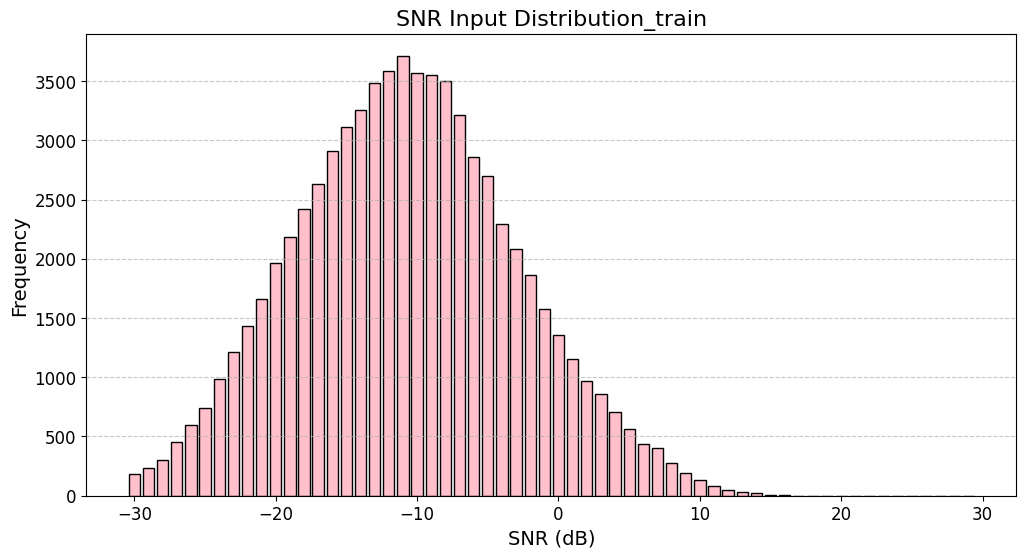

Saved bar plot to /content/drive/MyDrive/snr_train_distribution_plot.png


In [ ]:
# Load the data from the Excel file
excel_file_path = '/content/drive/MyDrive/model.xlsx'
df = pd.read_excel(excel_file_path)

# Define the bin edges
bins = np.arange(-30.5, 30.5, 1)  # Bins from -30 to 30 with step size 1

# Create a new column for binned SNR values
df['SNR Binned'] = pd.cut(df['SNR Input'], bins=bins, labels=np.arange(-30, 30))

# Count the frequencies for each bin
snr_counts = df['SNR Binned'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(snr_counts.index.astype(int), snr_counts.values, color='pink', edgecolor='black')
plt.title('SNR Input Distribution_train', fontsize=16)
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and show the plot
plot_file_path = '/content/drive/MyDrive/snr_train_distribution_plot.png'
plt.savefig(plot_file_path, dpi=1000)
plt.show()

print(f'Saved bar plot to {plot_file_path}')
